In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch    
from sklearn.decomposition import PCA
import hydra

from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import *
from openretina.models.core_readout import load_core_readout_from_remote, load_core_readout_model
from openretina.data_io.hoefling_2024.stimuli import movies_from_pickle
from openretina.utils.file_utils import get_local_file_path


# Load model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = load_core_readout_from_remote(
#     "karamanlis_2024_base", device="cuda" if torch.cuda.is_available() else "cpu"
# )
model = load_core_readout_model(
    "/home/baptiste/Documents/LabPipelines/open-retina/openretina_assets/runs/core_readout_goldin_2022/2025-09-01_10-50-49/checkpoints/epoch=69_val_correlation=0.000.ckpt",
    is_gru_model=False,
    is_klindt_readout=True,
    device="cuda" if torch.cuda.is_available() else "cpu",
)
model

CoreKlindtReadout(
  (core): <super: <class 'Core'>, <SimpleCoreWrapper object>> [SimpleCoreWrapper regularizers: gamma_hidden = 0.0|gamma_in_sparse = 0.0|gamma_input = 0.4654576767872573|gamma_temporal = 0.0]
  
  (readout): MultiKlindtReadoutWrapper(
    (mouse-session-1_structured_data): KlindtReadoutWrapper3D(
      (_input_weights_regularizer_spatial): FlatLaplaceL23dnorm(
        (laplace): Laplace()
      )
    ) [KlindtReadoutWrapper3D]
    
  )
  (loss): PoissonLoss3d()
  (correlation_loss): CorrelationLoss3d()
)

In [3]:
# pick a random session
session_id = list(model.readout.keys())[-1]
print(session_id)
n_neurons = model.readout[session_id].outdims
print(f"Number of neurons: {n_neurons}")

mouse-session-1_structured_data
Number of neurons: 41


# Load natural images

In [4]:
from openretina.data_io.goldin_2022.stimuli import load_all_stimuli
# Load training images (Feel free to use another dataset instead but make sure the preprocessing is correct)
movies = load_all_stimuli(base_data_path='/home/baptiste/Documents/LabPipelines/open-retina/notebooks/data/omarre_lab/goldin_2022',
                          normalize_stimuli=True)

dict_keys(['mouse-session-1_structured_data'])


In [5]:
# HOTFIX : Add input_shape to data_info to keep the original function intact
model.data_info = {}
model.data_info['input_shape'] = movies[session_id].train.swapaxes(0, 1).shape[1:]
# movies[session_id].train.expand_dims(1)
# movies= np.expand_dims(movies[session_id].train, axis=1)
movies = movies[session_id].train.swapaxes(0, 1)  # put channels first

In [6]:
movies, n_empty_frames = prepare_movies_dataset(model, session_id, device = device, image_library = movies, normalize_movies=False)

Model input shape: (1, 108, 108)
Using provided image library with shape: (3160, 1, 108, 108)
Image stats- Mean: 0.00, Std: 1.00, Min: -2.401987075805664, Max: 2.4789223670959473
Number of empty frames needed: 10
Final movies shape: (3160, 1, 26, 108, 108)


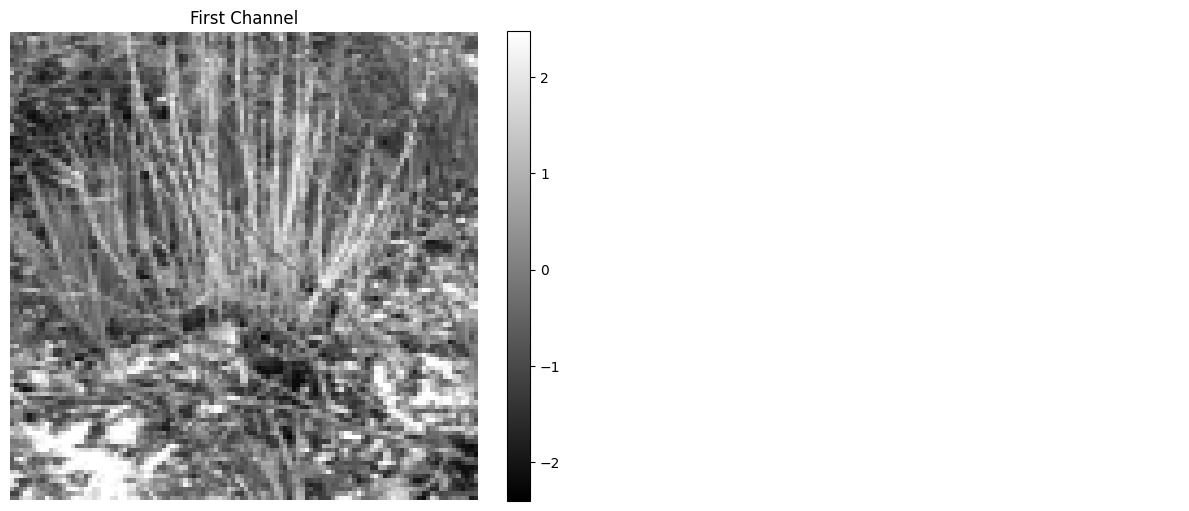

First channel range on this image: [-2.386, 2.479]


In [7]:
# Display the last frame of an example movie with both channels side by side
example_idx = 20  # First movie as example
last_frame = movies[example_idx, :, -1, :, :]  # Shape: (2, 72, 64)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First channel (channel 0)
im1 = axes[0].imshow(last_frame[0], cmap='grey', vmin=movies[:, 0, :, :].min(), vmax=movies[:, 0, :, :].max())
axes[0].set_title('First Channel')
plt.colorbar(im1, ax=axes[0])
axes[0].axis('off')
# Optional : Second channel (channel 1) 
# im2 = axes[1].imshow(last_frame[1], cmap='Purples', vmin=movies[:, 1, :, :].min(), vmax=movies[:, 1, :, :].max())
# axes[1].set_title('Second Channel')
# # plt.colorbar(im2, ax=axes[1])
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f"First channel range on this image: [{last_frame[0].min():.3f}, {last_frame[0].max():.3f}]")
# print(f"Second channel range: [{last_frame[1].min():.3f}, {last_frame[1].max():.3f}]")

In [19]:
cell_id = 10 # LInear example | On Karamanlis cell_id = 33 NONLINEAR Example
lsta_library, response_library = compute_lsta_library(model, movies, session_id, cell_id, batch_size=64, device=device)

Text(0, 0.5, 'Cell predicted Response (au)')

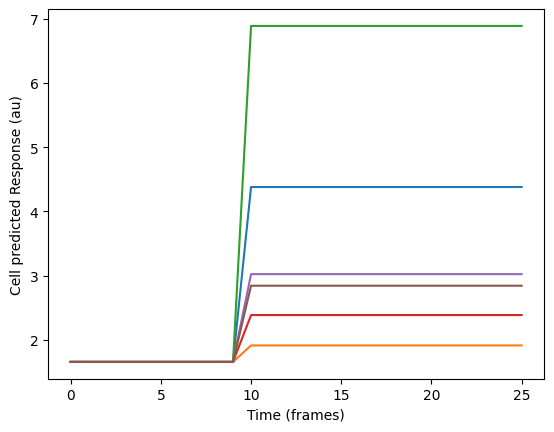

In [20]:
# We can check some sample responses, making sure the integrity of the response profile is predicted and we did not cut it too short.

plt.plot(response_library[0, :, cell_id])
plt.plot(response_library[1, :, cell_id])
plt.plot(response_library[2, :, cell_id])
plt.plot(response_library[3, :, cell_id])
plt.plot(response_library[4, :, cell_id])
plt.plot(response_library[5, :, cell_id])
plt.xlabel('Time (frames)')
plt.ylabel('Cell predicted Response (au)')

In [21]:
lsta_library.shape

(3160, 1, 108, 108)

In [22]:
lsta_library.mean()
lsta_library.max()
lsta_library.var()

np.float32(5.685153e-07)

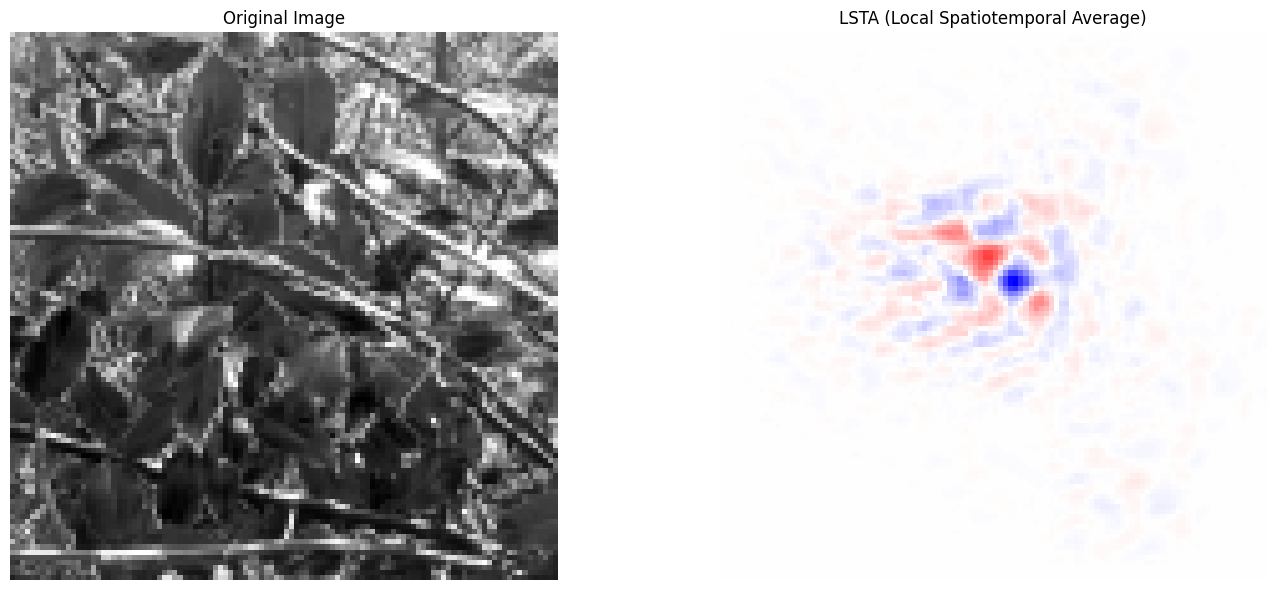

In [23]:
# We can now plot an example LSTA and the corresponding image

image = 375
channel = 0
lsta = lsta_library[image, channel]
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# image
axes[0].imshow(movies[image,0,-1], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# LSTA
axes[1].imshow(lsta, cmap='bwr', vmin=-abs(lsta).max(), vmax=abs(lsta).max())
axes[1].set_title('LSTA (Local Spatiotemporal Average)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Do PCA on the LSTA library

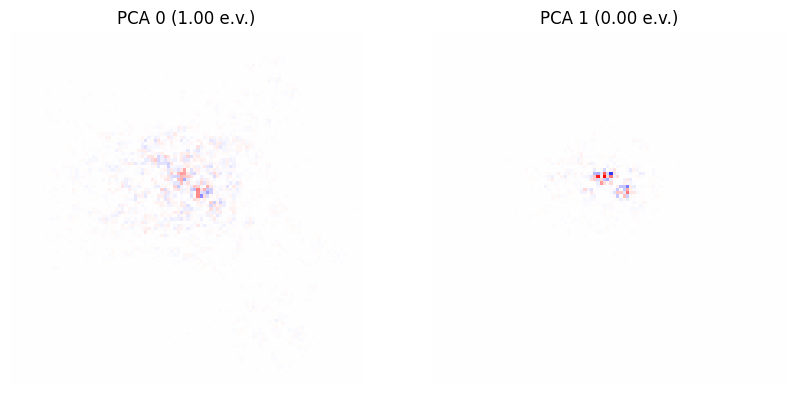

In [24]:
# Select channel
channel = 0
# lsta_library = lsta_library[:, :, :]

PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)

In [25]:
# Project the images onto PCA space
images = movies[:,channel,-1,:,:]
images_coordinate = get_images_coordinate(images, PC1, PC2, plot=False)

images_coordinate

array([[ 0.8419661 ,  0.09602361],
       [-0.54956263, -0.74832994],
       [-1.1553837 , -0.2628961 ],
       ...,
       [-0.97266877, -1.443771  ],
       [ 0.6130127 ,  0.7112231 ],
       [-0.43642998,  0.22913416]], shape=(3160, 2), dtype=float32)

In [26]:
images_coordinate.shape, lsta_library.shape

((3160, 2), (3160, 1, 108, 108))

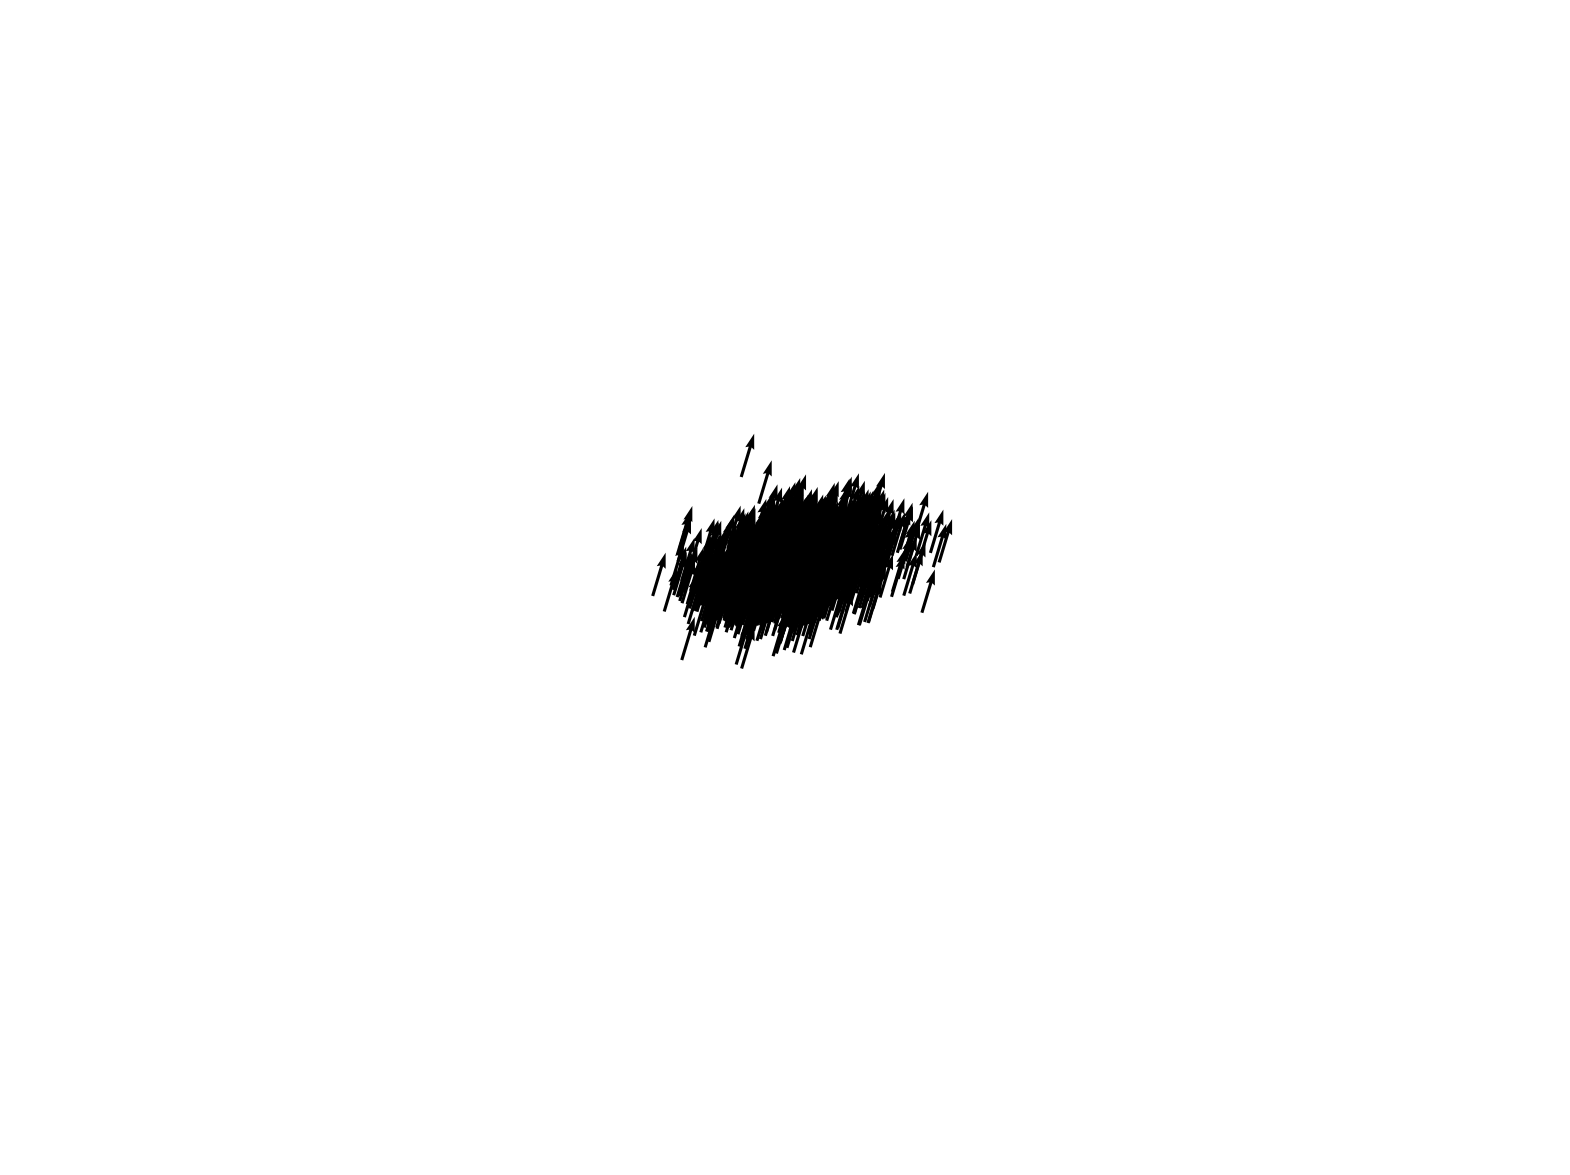

In [27]:
# Plot the vector field of the LSTA in PCA space
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_untreated_vectorfield

fig = plot_untreated_vectorfield(lsta_library, PC1, PC2, images_coordinate)

/tmp/ipykernel_23566/2947602511.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


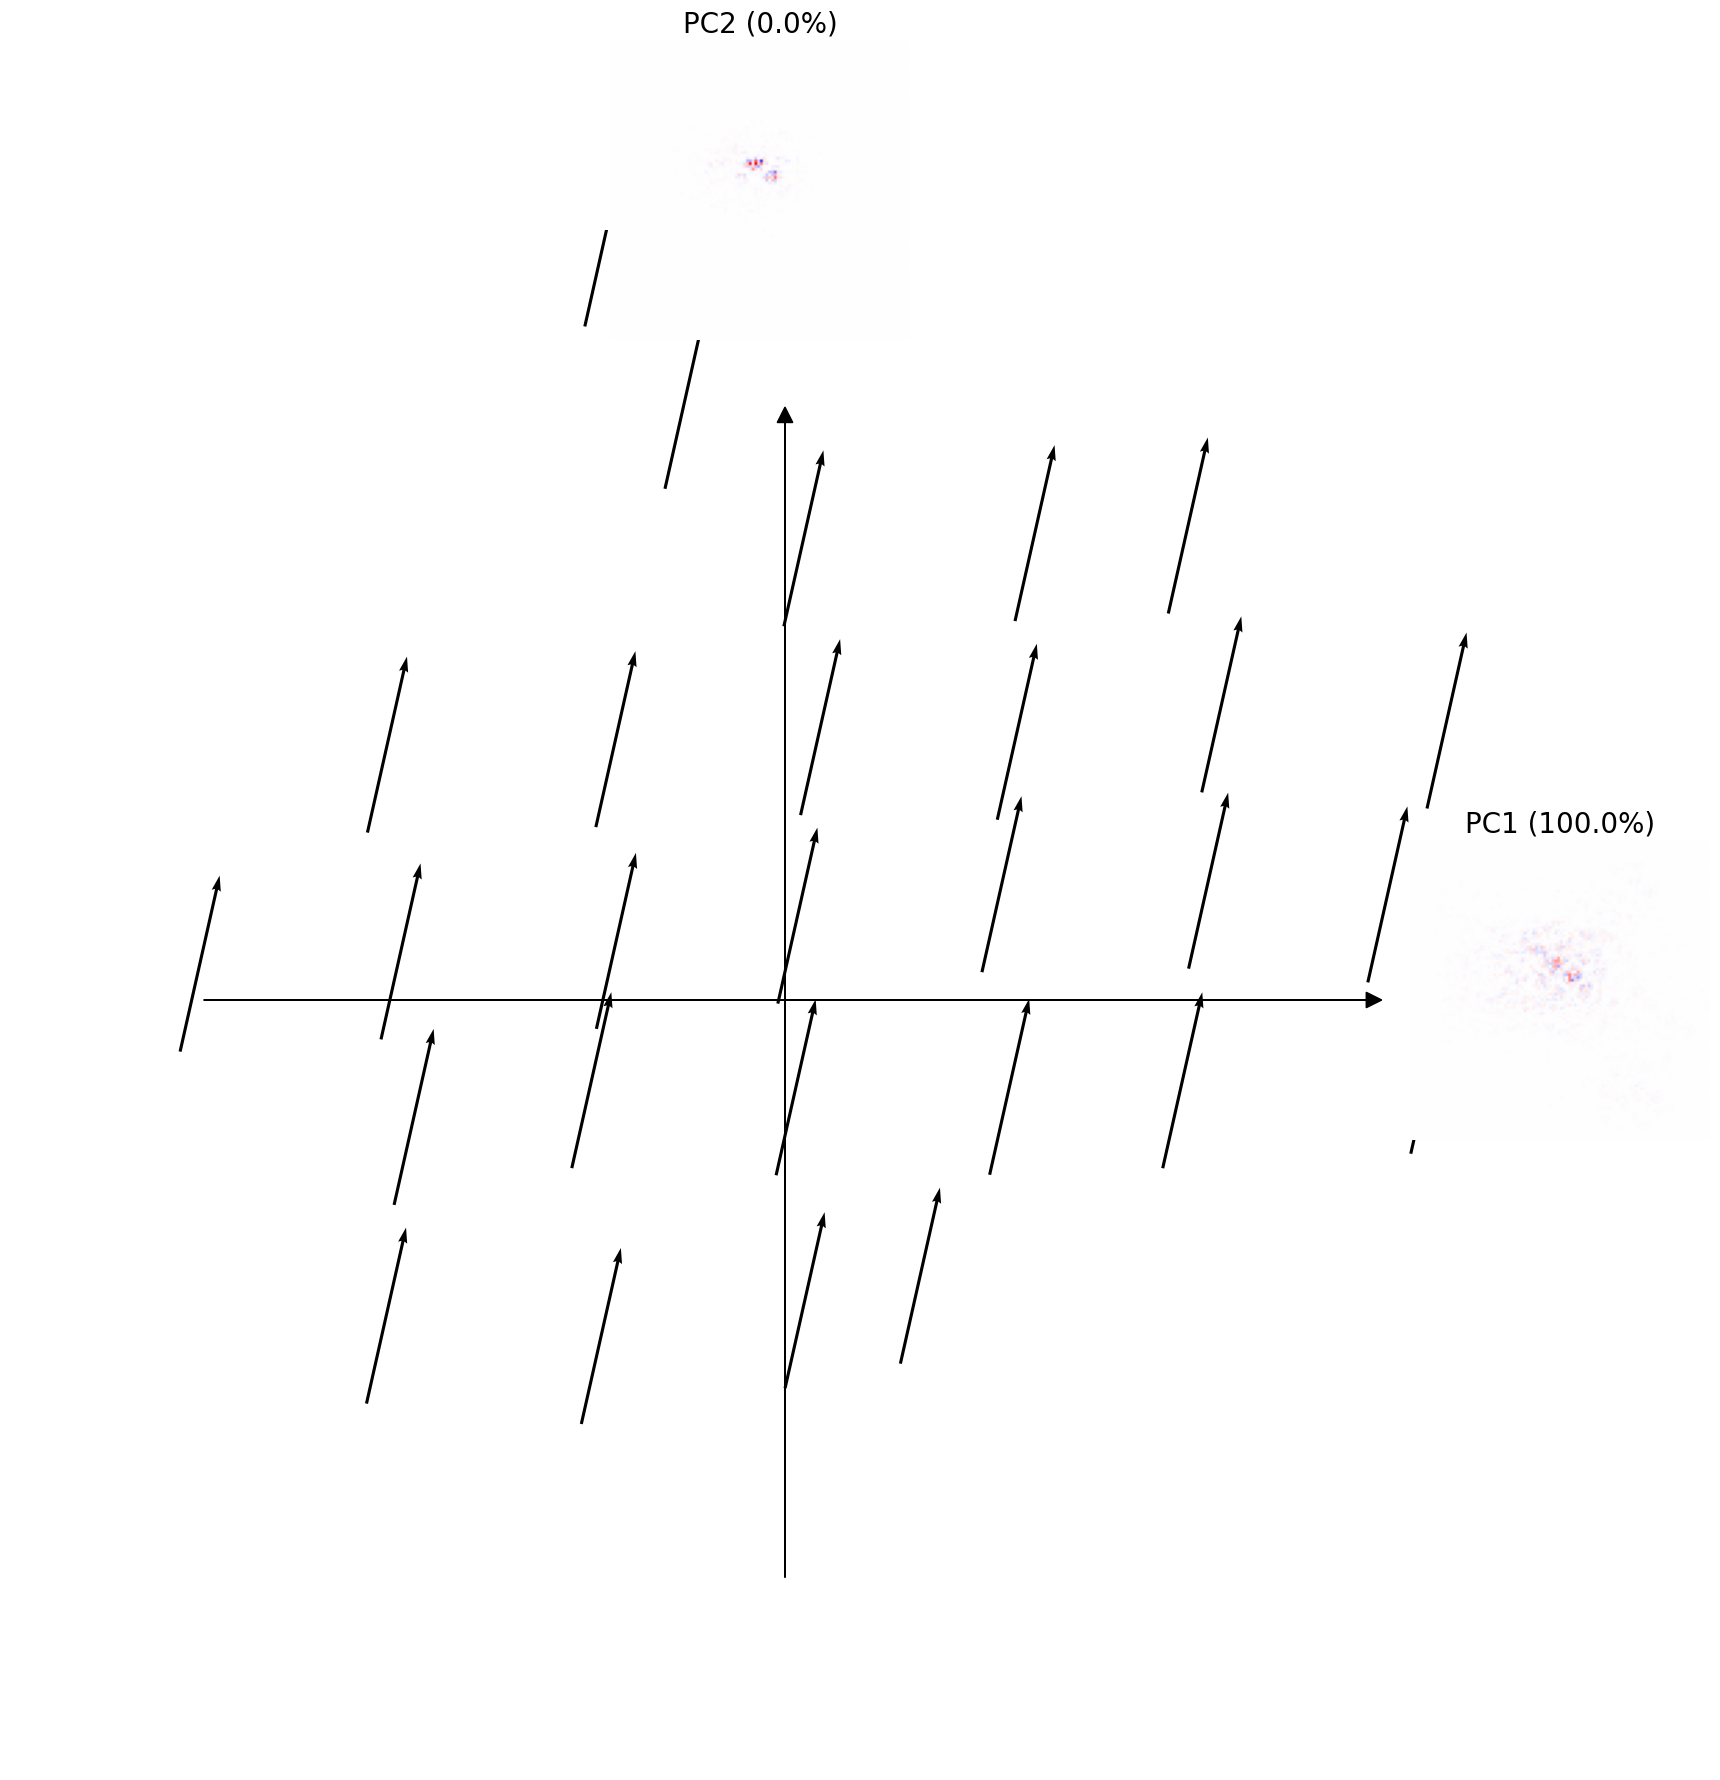

In [28]:
from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_clean_vectorfield
fig = plot_clean_vectorfield(
    lsta_library,
    channel,
    PC1,
    PC2,
    images,
    images_coordinate,
    explained_variance,
    x_bins=31,
    y_bins=31,
)
fig.show()

# ADD the firing rate by the side + mention cell types

# Create all arrowplots of a session

In [29]:
# from openretina.insilico.VectorFieldAnalysis.vector_field_analysis import plot_clean_vectorfield


# for cell_id in range(n_neurons):
#     print(f"Processing cell {cell_id}...")
#     lsta_library, response_library = compute_lsta_library(model, movies, session_id, cell_id, batch_size=64, device=device)
#     PC1, PC2, explained_variance = get_pc_from_pca(model, channel, lsta_library, plot=True)
#     images_coordinate = get_images_coordinate(images, PC1, PC2, plot=False)
#     fig = plot_clean_vectorfield(
#         lsta_library,
#         channel,
#         PC1,
#         PC2,
#         images,
#         images_coordinate,
#         explained_variance,
#         x_bins=31,
#         y_bins=31,
#     )
#     fig.savefig(f"goldin_2022_vector_fields/cell_{cell_id}_mouse.png", dpi=300, bbox_inches='tight')
#     plt.close(fig)